# Distribution B - Fit from Samples

In [193]:
import DistBTrunc as dbt
import DistExampB as db

from math import ceil, floor, sqrt
from matplotlib import pyplot as plot
from sympy import Symbol

from LocMath import Sqr
from LocUtil import Grid1, LogGrid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio
from Sinc import FitLstSqr, Interp

In [194]:
nSamp = 1_600

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

In [195]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

samp = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 604


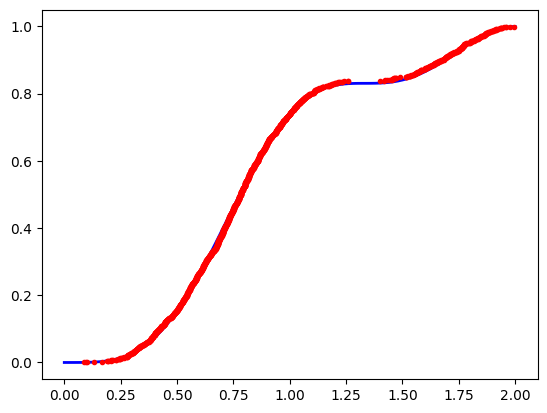

In [196]:
plot.plot(samp,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Map to Z

In [197]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [198]:
map_.forSym

log(x/(2 - x))

In [199]:
sampZ = tuple(map_.Forward(x) for x in samp)

In [200]:
zRange = MinMax(sampZ)
zRange

(-3.0922057392990103, 5.689106966178293)

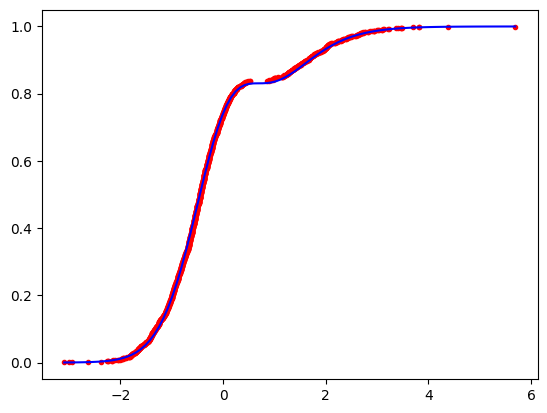

In [201]:
plot.plot(sampZ,quant, '.', c='red')

zGrid = Grid1(*zRange, nPlot)
nullGrid = [dist.Cdf(map_.Inverse(z)) for z in zGrid]
plot.plot(zGrid,nullGrid, c='blue')

## Residue

In [202]:
sampRes = tuple(q - dbt.NullZ(z) for (z,q) in zip(sampZ, quant))

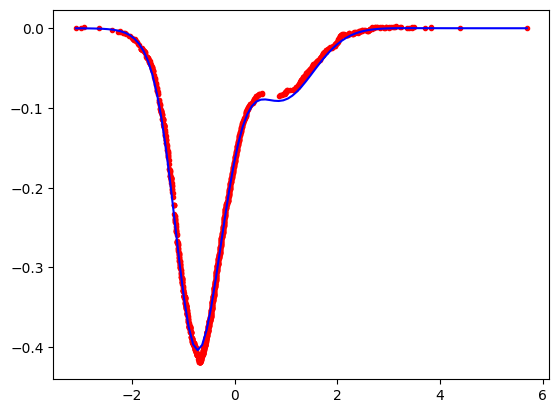

In [203]:
plot.plot(sampZ,sampRes, '.', c='red')

resGrid = tuple(dbt.ResZ(z) for z in zGrid)
plot.plot(zGrid,resGrid, c='blue')

### Sinc Fit

In [204]:
zLim = MinMax(sampZ)
zMin,zMax = zLim
zMin,zMax

(-3.0922057392990103, 5.689106966178293)

In [205]:
zRange = zMax - zMin
zRange

8.781312705477303

In [206]:
hMin,hMax = 0.2,3

In [207]:
nMin = ceil(zRange / hMax) + 1
nMin

4

In [208]:
nMax = floor(zRange / hMin) + 1
nMax

44

In [209]:
nL = tuple(range(nMin, nMax + 1))

In [210]:
sampPoint = tuple(zip(sampZ, sampRes))

In [211]:
fitTab = tuple((n, *FitLstSqr(sampPoint, zLim,n)) for n in nL)

Text(0, 0.5, 'Residue')

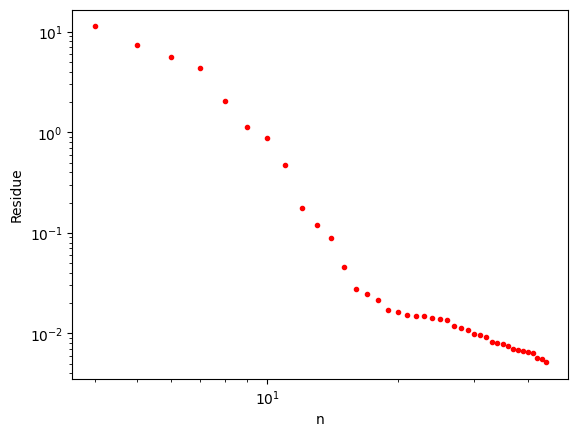

In [212]:
res = tuple(r for (_,_,r,_) in fitTab)
plot.loglog(nL, res, '.', c='red')

plot.xlabel('n')
plot.ylabel('Residue')

Text(0, 0.5, 'Condition Number')

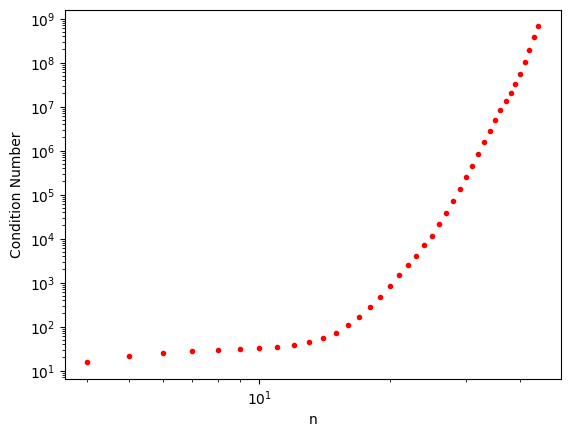

In [213]:
cond = tuple(c for (_,_,_,c) in fitTab)
plot.loglog(nL, cond, '.', c='red')

plot.xlabel('n')
plot.ylabel('Condition Number')

#### Individual fits

In [214]:
fitRes = FitLstSqr(sampPoint, zLim,3)
sincPoint = fitRes[0]

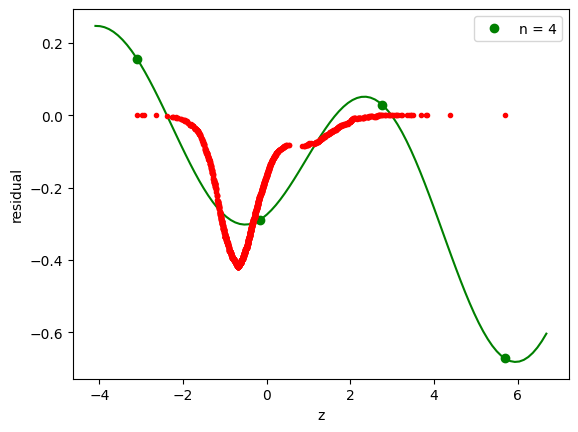

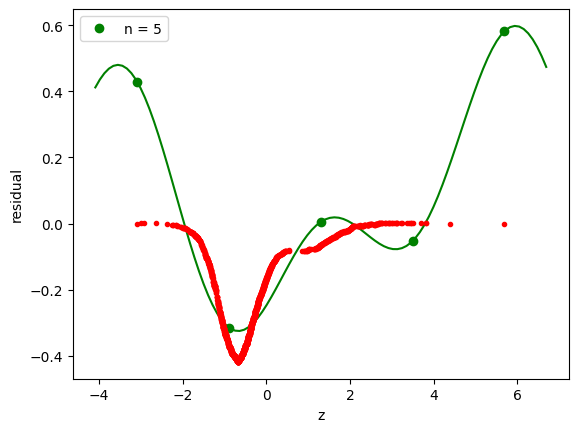

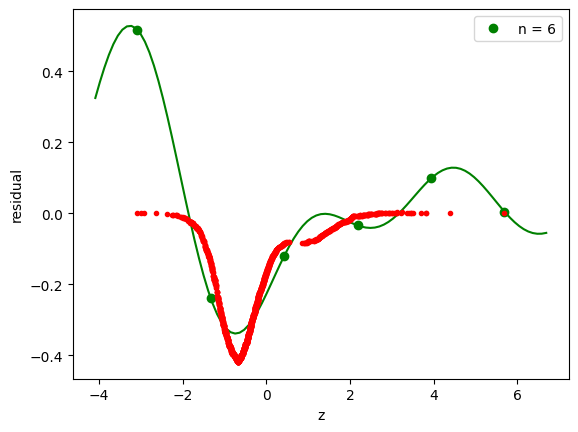

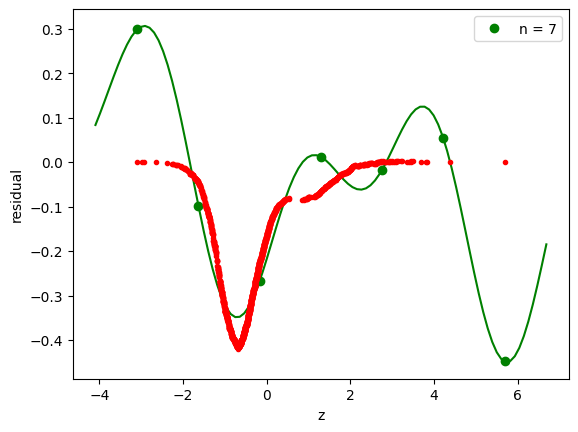

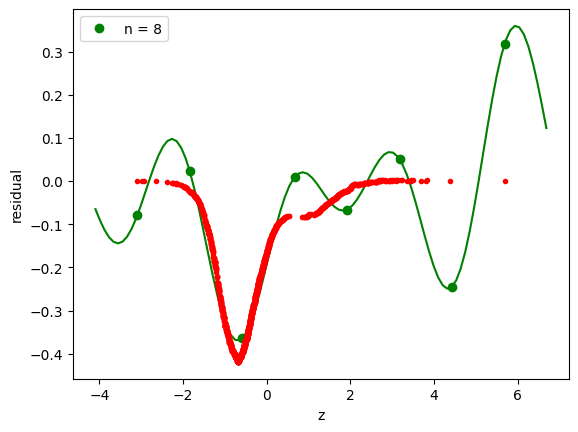

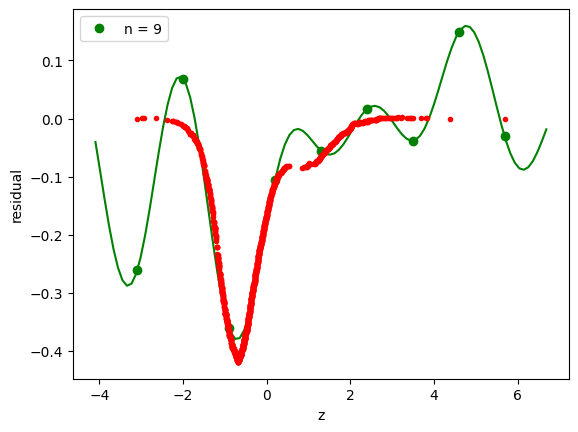

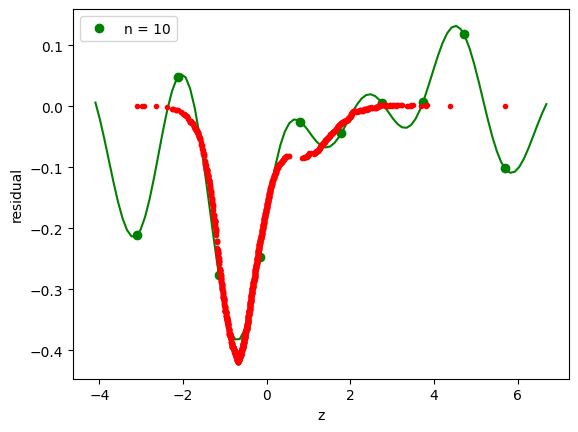

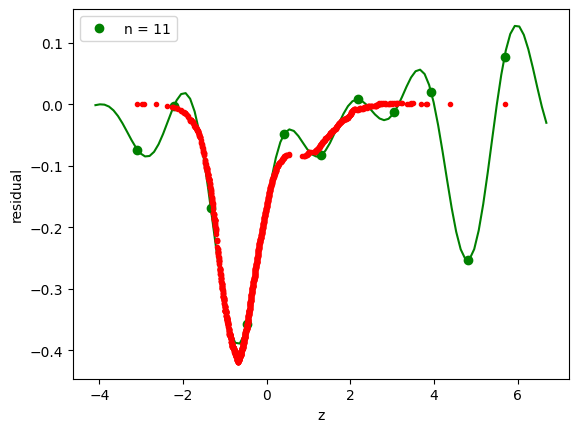

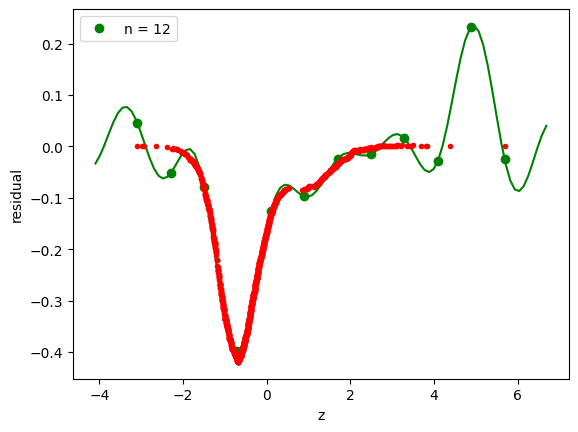

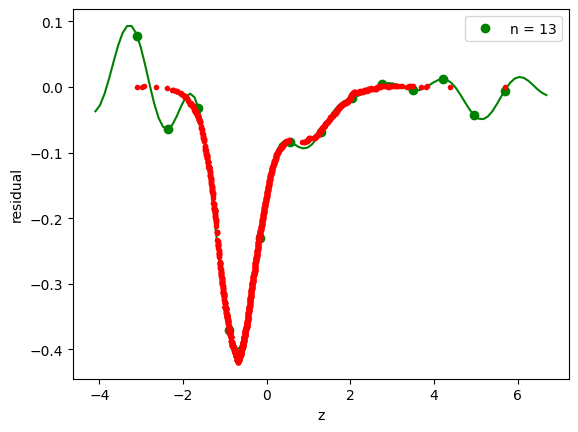

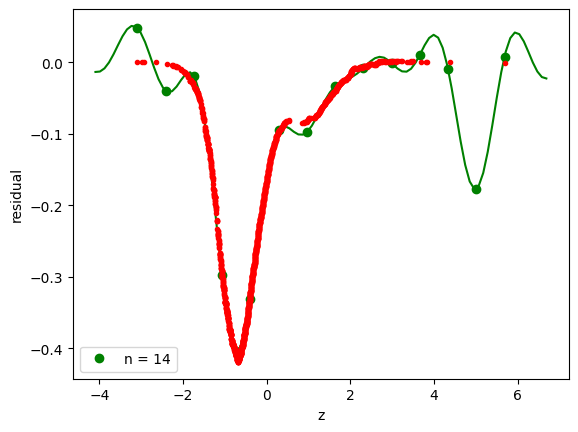

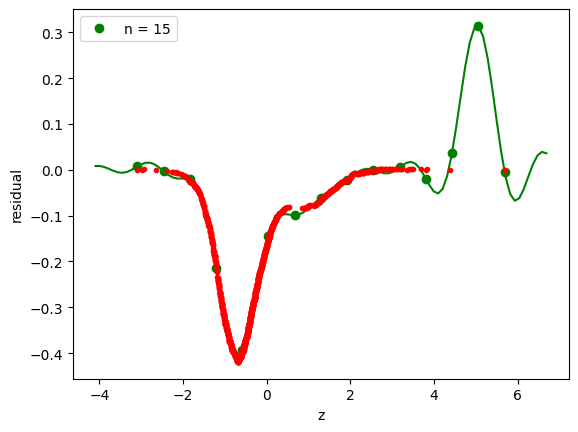

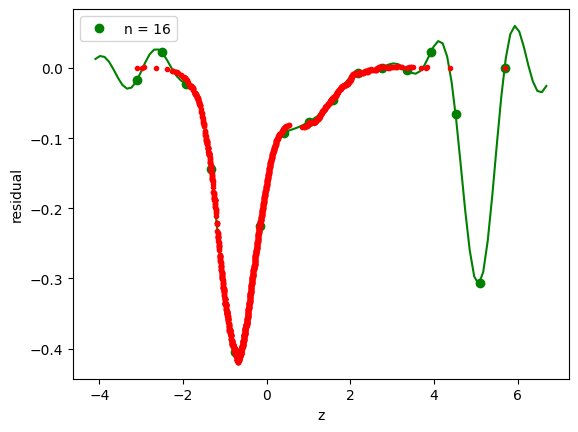

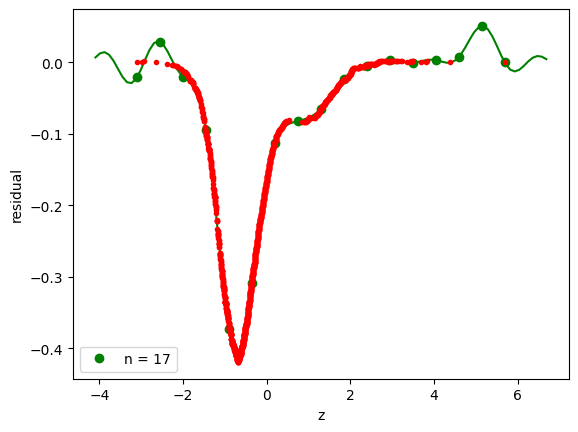

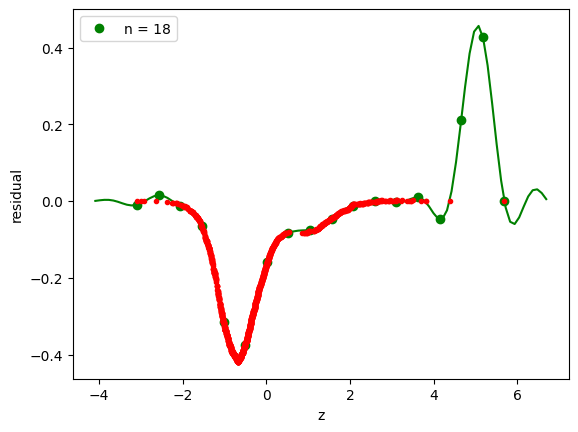

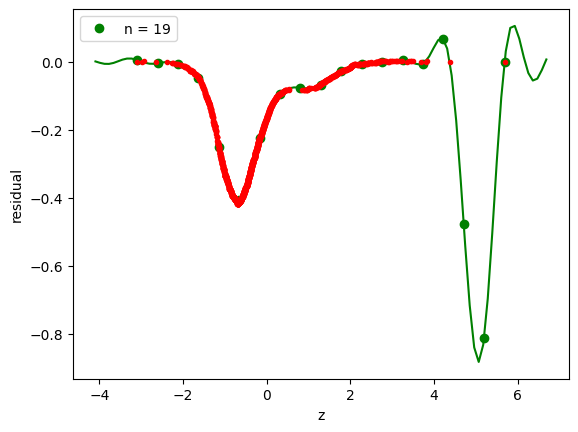

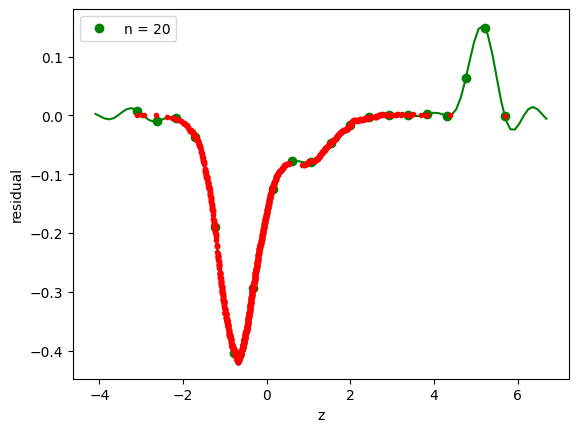

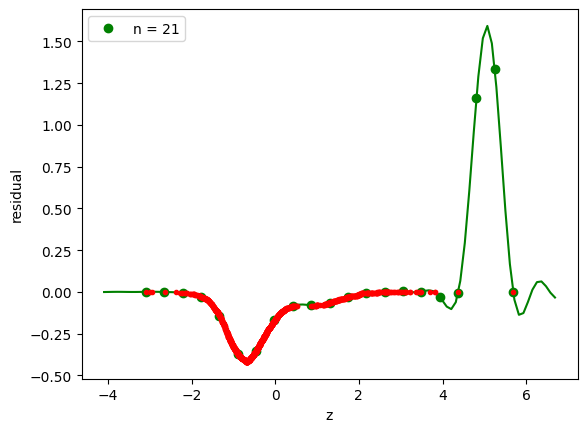

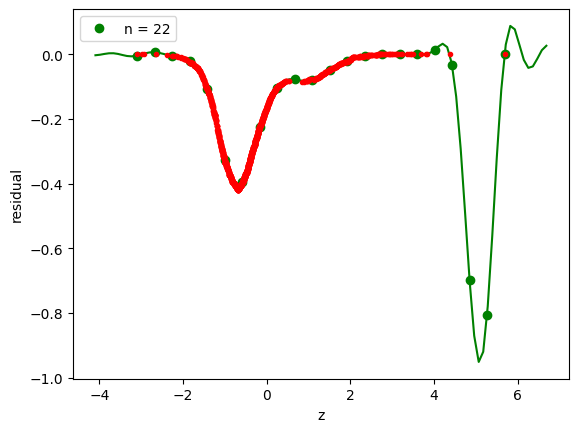

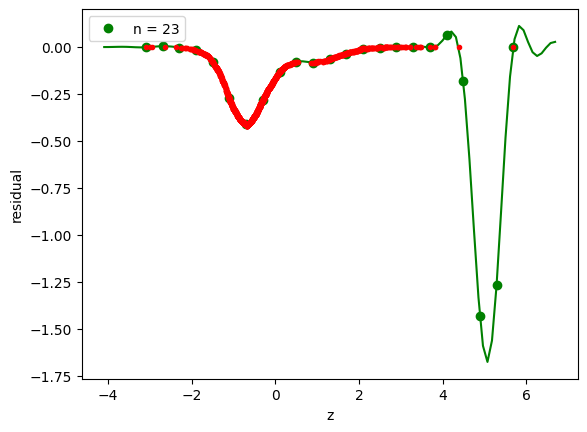

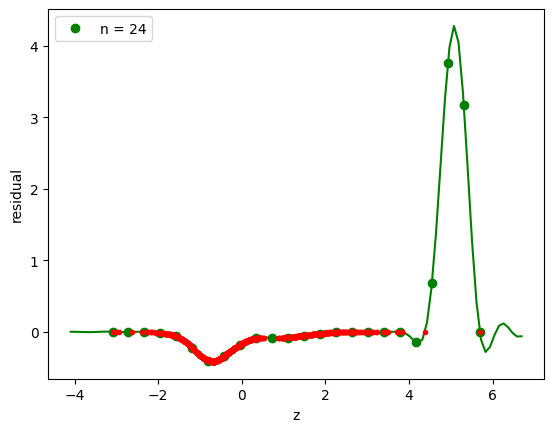

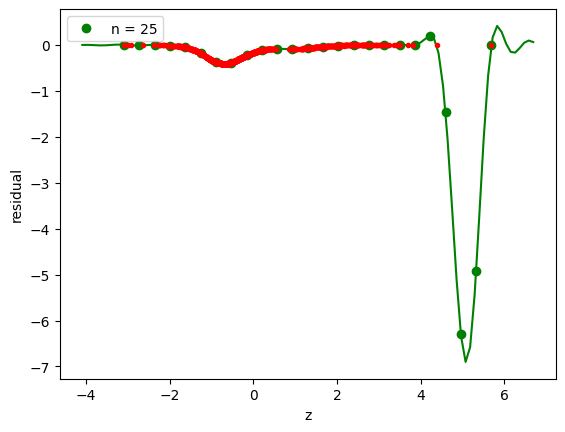

In [215]:
for (n,sincPoint,_,_) in fitTab[:(25 - 3)]:
	plot.plot(*UnZip(sincPoint), 'o', markersize=6, c='green', label=f'n = {n}')
		
	zGrid = Grid1(zMin - 1, zMax + 1, nPlot)
	interpV = Interp(sincPoint, zGrid)
	plot.plot(zGrid,interpV, c='green')	
	
	plot.plot(*UnZip(sampPoint), '.', c='red')
	
	plot.xlabel('z')
	plot.ylabel('residual')
	plot.legend()
	
	plot.show()

## Do L-Infinity of Least Squares Fit

In [216]:
def LInf(sincPoint, sampPoint):
	sampZ,sampV = UnZip(sampPoint)
	
	interpV = Interp(sincPoint, sampZ)
	diff = tuple(sV - eV for (eV,sV) in zip(sampV, interpV))
	result = max(abs(d) for d in diff)
	
	return result

In [217]:
fitTab[0]

(4,
 ((-3.0922057392990103, 0.15534230134382748),
  (-0.16510150413990932, -0.2891037365735711),
  (2.7620027310191917, 0.029673390850340084),
  (5.689106966178293, -0.6711547525262724)),
 11.320936665034614,
 15.369256771821862)

Text(0, 0.5, 'L-Infinity')

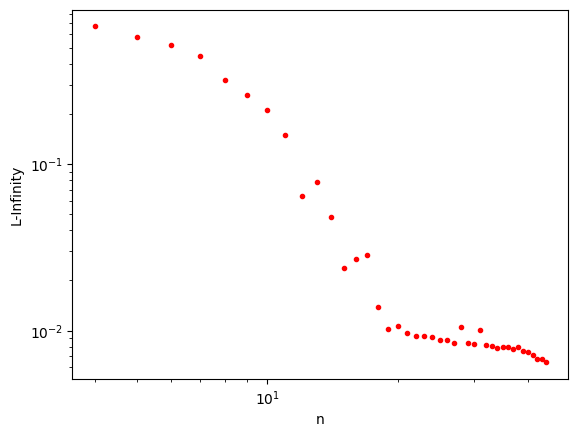

In [218]:
lInf = tuple(LInf(sincPoint, sampPoint) for (_,sincPoint,_,_) in fitTab)
plot.loglog(nL, lInf, '.', c='red')

plot.xlabel('n')
plot.ylabel('L-Infinity')

## Do RMS Deviation from True Residual

In [219]:
rms = tuple(
	sqrt(sum(Sqr(dbt.ResZ(z) - v) for (z,v) in sincPoint) / n) 
	for (n,sincPoint,_,_) in fitTab
)

Text(0, 0.5, 'RMS Error')

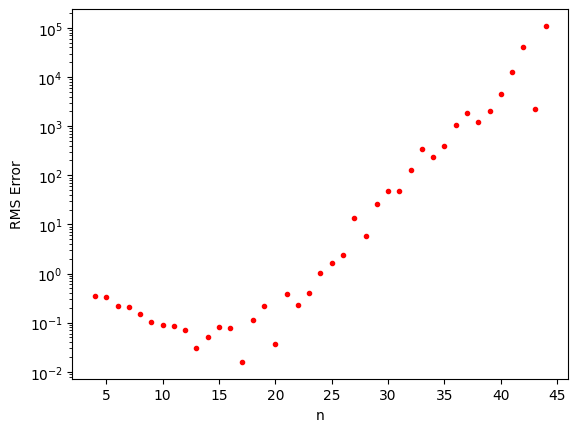

In [220]:
plot.semilogy(nL,rms, '.', c='red')

plot.xlabel('n')
plot.ylabel('RMS Error')

In [221]:
fitTab[MinIndex(rms)][0], min(rms)

(17, 0.015907899757483645)